In [48]:
import arviz as az
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import numpy as np
import pandas as pd
import pymc as pm
import preliz as pz
import xarray as xr

from scipy.special import logsumexp

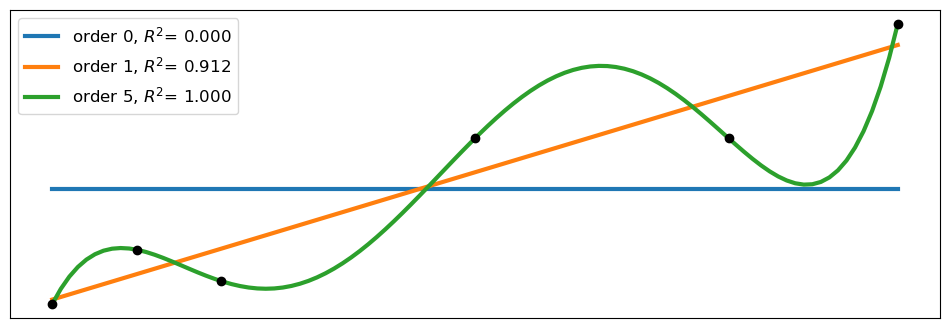

In [3]:
_, ax = plt.subplots(1, 1, figsize=(12, 4))


x0 = np.array([4.0, 5.0, 6.0, 9.0, 12, 14.0])
y0 = np.array([4.2, 6.1, 5.0, 10.0, 10, 14.0])

order = [0, 1, 5]
ax.plot(x0, y0, "ko", zorder=3)


ax.set_yticks([])
ax.set_xticks([])

x_n = np.linspace(x0.min(), x0.max(), 100)
ps = []
for i in order:
    p = np.polynomial.Polynomial.fit(x0, y0, deg=i)
    ps.append(p)
    yhat = p(x0)
    ybar = np.mean(y0)
    ss_regression = np.sum((yhat - y0) ** 2)
    ss_total = np.sum((ybar - y0) ** 2)
    r2 = 1 - ss_regression / ss_total
    ax.plot(x_n, p(x_n), label=f"order {i}, $R^2$= {r2:.3f}", lw=3)


ax.legend(loc=2, fontsize=12)
 

In [4]:
order = 5 
x_p = np.vstack([x0**i for i in range(1, order + 1)])
x_c = (x_p - x_p.mean(axis=1, keepdims=True)) / x_p.std(axis=1, keepdims=True)
y_c = (y0 - y0.mean()) / y0.std()

In [19]:
with pm.Model() as model_l:
    α = pm.Normal("α", mu=0, sigma=.2)
    β = pm.Normal("β", mu=0, sigma=1)
    σ = pm.Exponential("σ", 1)

    μ = α + β * x_c[0]

    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=y_c)

    idata_l = pm.sample(2000, idata_kwargs={"log_likelihood": True}, random_seed=4591)
    #idata_l.extend(pm.sample_posterior_predictive(idata_l, random_seed=4591))


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.


In [20]:
az.summary(idata_l, var_names=["~y_pred"])

/Users/ronaldlegere/miniconda3/envs/bap3/lib/python3.11/site-packages/arviz/utils.py:134: UserWarning: Items starting with ~: ['y_pred'] have not been found and will be ignored
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,0.002,0.128,-0.237,0.244,0.002,0.001,6116.0,5629.0,1.0
β,0.917,0.187,0.569,1.277,0.003,0.002,4320.0,3324.0,1.0
σ,0.446,0.189,0.195,0.784,0.003,0.003,3870.0,4181.0,1.0


/Users/ronaldlegere/miniconda3/envs/bap3/lib/python3.11/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


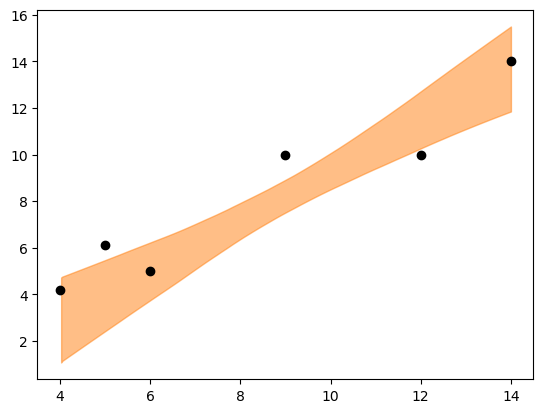

In [21]:
import xarray as xr
l_samps = az.extract(idata_l)
x_plot = np.linspace(np.min(x0), np.max(x0), 100)
x_plot_c = xr.DataArray((x_plot - x_plot.mean()) / x_plot.std())

y_plot = (l_samps['α'] + l_samps['β']* x_plot_c)*y0.std() + y0.mean()
az.plot_hdi(x_plot, y_plot, hdi_prob=.89, fill_kwargs={"alpha": .5})
plt.plot(x0, y0, "ko")  

In [22]:

order = 5
with pm.Model() as model_q:
    α = pm.Normal("α", mu=0, sigma=.2)
    β = pm.Normal("β", mu=0, sigma=1, shape=order)
    σ = pm.Exponential("σ",1)

    μ = α + pm.math.dot(β, x_c)

    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=y_c)

    idata_q = pm.sample(2000, target_accept = 0.95, idata_kwargs={"log_likelihood": True}, random_seed=4591)
    #idata_q.extend(pm.sample_posterior_predictive(idata_q, random_seed=4591))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 6 seconds.


In [23]:
az.summary(idata_q, var_names=["~y_pred"])

/Users/ronaldlegere/miniconda3/envs/bap3/lib/python3.11/site-packages/arviz/utils.py:134: UserWarning: Items starting with ~: ['y_pred'] have not been found and will be ignored
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,-0.001,0.133,-0.248,0.252,0.002,0.002,6833.0,4934.0,1.0
β[0],0.531,0.686,-0.793,1.816,0.010,0.007,4688.0,4695.0,1.0
β[1],0.224,0.850,-1.347,1.831,0.012,0.010,5275.0,5287.0,1.0
β[2],0.065,0.884,-1.605,1.707,0.012,0.011,5821.0,5048.0,1.0
β[3],0.040,0.836,-1.551,1.567,0.012,0.009,5203.0,4799.0,1.0
β[4],0.088,0.741,-1.262,1.500,0.010,0.008,5439.0,5253.0,1.0
σ,0.498,0.229,0.202,0.878,0.004,0.003,3355.0,4059.0,1.0


Overfitting manifests as large parameter uncertainties

In [24]:
import xarray as xr
q_samps = az.extract(idata_q)
x_plot = np.linspace(np.min(x0), np.max(x0), 100)
x_plot_p = xr.DataArray(np.vstack([x_plot**i for i in range(1, order + 1)]), dims = ['β_dim_0','x_dim_0'])
x_plot_c = (x_plot_p - x_p.mean(axis=1, keepdims=True)) / x_p.std(axis=1, keepdims=True)

y_plot = (q_samps['α'] + xr.dot(q_samps['β'], x_plot_c))*y0.std() + y0.mean()

/Users/ronaldlegere/miniconda3/envs/bap3/lib/python3.11/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


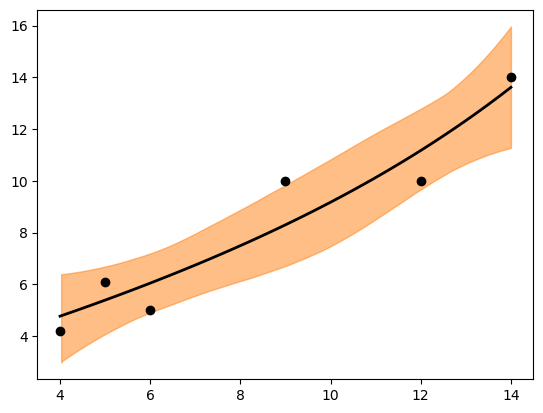

In [25]:
az.plot_hdi(x_plot, y_plot, hdi_prob=.89, fill_kwargs={"alpha": .5})
y_pred_mean = y_plot.mean(dim='sample')
plt.plot(x_plot, y_pred_mean, "k", lw=2)
plt.plot(x0, y0, "ko")  

Note that unlike the standard regression, the Bayesian regression is robust to overfitting in that predictions are still relatively smooth. 

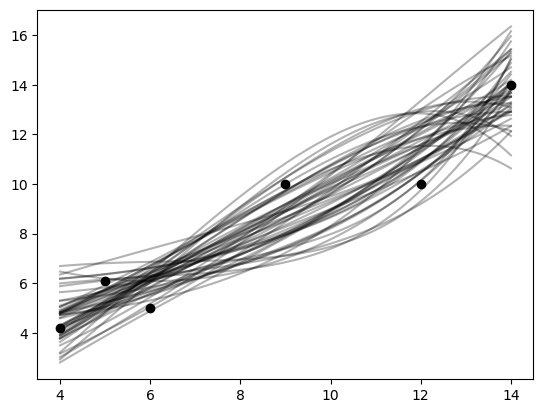

In [26]:
# plot 50 sample regression lines
for i in range(50):
    plt.plot(x_plot, (q_samps['α'][i] + xr.dot(q_samps['β'].isel(sample = i), x_plot_c))*y0.std() + y0.mean(), "k", alpha=.3)

plt.plot(x0, y0, "ko");  

In [16]:
# Compare the two models using pLoo:
loo_l = az.loo(idata_l)
loo_q = az.loo(idata_q)
az.compare({"linear": idata_l, "quadratic": idata_q})

/Users/ronaldlegere/miniconda3/envs/bap3/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/ronaldlegere/miniconda3/envs/bap3/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/ronaldlegere/minicond

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
linear,0,-3.990469,1.662565,0.000000,1.000000e+00,0.634429,0.000000,False,log
quadratic,1,-5.486972,2.701249,1.496503,2.220446e-16,0.975120,0.911841,True,log


So the linear is better, but not sure it qualifies as overfitting.

Let's take a look at doing leave one out manually, to faciliate this lets define a model builder:

In [82]:
def fit_model(order, leave_out = None, return_inf = False):
    x_p = np.vstack([x0**i for i in range(1, order + 1)])
    x_c = (x_p - x_p.mean(axis=1, keepdims=True)) / x_p.std(axis=1, keepdims=True)
    y_c = (y0 - y0.mean()) / y0.std()
    if leave_out is not None:
        y_loo = y_c[leave_out]
        x_loo = x_c[:, leave_out]
        x_c = np.delete(x_c, leave_out, axis=1)
        y_c = np.delete(y_c, leave_out)
    with pm.Model() as model:
        α = pm.Normal("α", mu=0, sigma=.2)
        β = pm.Normal("β", mu=0, sigma=1, shape=order)
        σ = pm.Exponential("σ",1)

        μ = α + pm.math.dot(β, x_c)

        y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=y_c)

        idata= pm.sample(1000, target_accept = 0.95, random_seed=4591)

    if leave_out is not None:
        samps = az.extract(idata)
        y_loo_pred = samps['α'].values + np.dot(samps['β'].values.T,  x_loo)
        lpd = logsumexp(-0.5*((y_loo -  y_loo_pred)/samps['σ'].values)**2 - \
                        0.5*np.log(2*np.pi)-np.log(samps['σ'].values)) - \
                        np.log(samps.sizes['sample']) 

    if return_inf:
        return model, idata, lpd
    return lpd

 

In [ ]:
lpds = [fit_model(5, leave_out = i) for i in range(len(x0))]

In [ ]:
lpds1 = [fit_model(1, leave_out = i) for i in range(len(x0))]

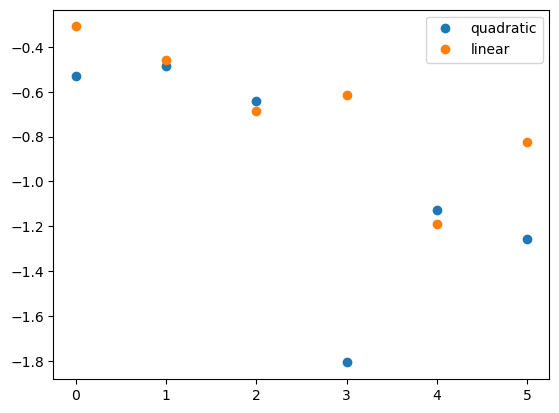

In [80]:
# plot the two lpds 
plt.plot(lpds, "o", label="quadratic")
plt.plot(lpds1, "o", label="linear")
plt.legend();

Note that it is the 4th data point that is worst for the quadratic model. 

In [81]:
(np.sum(lpds),np.sum(lpds1))

(-5.849796316650326, -4.080451953884432)

This agrees well with the approximate loo calculations above.

Lets look at the fourth data point:

In [83]:
(model , idata, lpd) = fit_model(5, leave_out =3, return_inf = True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


/Users/ronaldlegere/miniconda3/envs/bap3/lib/python3.11/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


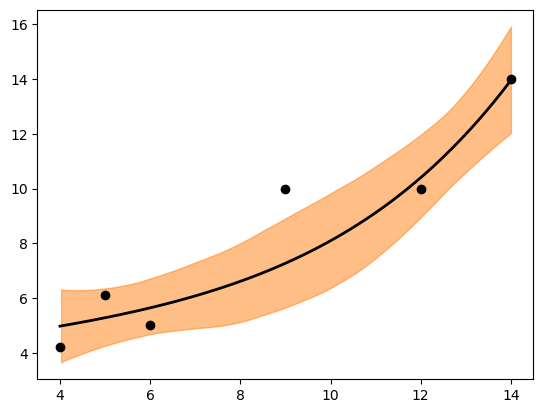

In [84]:
order = 5 
samps = az.extract(idata)
x_plot = np.linspace(np.min(x0), np.max(x0), 100)
x_plot_p = xr.DataArray(np.vstack([x_plot**i for i in range(1, order + 1)]), dims = ['β_dim_0','x_dim_0'])
x_plot_c = (x_plot_p - x_p.mean(axis=1, keepdims=True)) / x_p.std(axis=1, keepdims=True)

y_plot = (samps['α'] + xr.dot(samps['β'], x_plot_c))*y0.std() + y0.mean()

az.plot_hdi(x_plot, y_plot, hdi_prob=.89, fill_kwargs={"alpha": .5})
y_pred_mean = y_plot.mean(dim='sample')
plt.plot(x_plot, y_pred_mean, "k", lw=2)
plt.plot(x0, y0, "ko")  

So you can see what happened, without that point the model put more importance on the last two points and curved more!

This demostrates that overfitting does occur, it is just more tame in the Bayesian setting.